In [1]:
import numpy as np
import skan
from scipy import ndimage as ndi
from tifffile import imsave

def dendrite_pruning(skeleton_image,distance_transform):
    n_path=-1
    pruned_image=np.zeros([3,np.shape(skeleton_image)[0],np.shape(skeleton_image)[1],np.shape(skeleton_image)[2]])
    skeleton_image[distance_transform==1] = 0
    while n_path!=0:
        skeleton_object = skan.Skeleton(skeleton_image)
        summary=skan.summarize(skeleton_object)
        paths=skeleton_object.paths_list()
        
        path_num=len(paths)
        print(path_num,n_path)
        if(path_num==n_path):
            pruned_image[0,:,:,:] = skeleton_image
            pruned_image[2,:,:,:] = distance_transform
            for i in range(len(src)):
                pruned_image[1,coordinates[src[i],0],coordinates[src[i],1],coordinates[src[i],2]]=euclidean_distance[i]
                pruned_image[1,coordinates[dst[i],0],coordinates[dst[i],1],coordinates[dst[i],2]]=euclidean_distance[i]
            imsave('images/pruned_skeleton.tif', np.einsum('ijkl->lijk', pruned_image))
            return skeleton_object
        else:
            n_path=len(paths)
        
        t1_branch = np.where(summary['branch-type']==1)[0]
        t2_branch = np.where(summary['branch-type']==2)[0]
        src=[i[0] for i in paths]
        dst=[i[-1] for i in paths]

        coordinates = np.array((skeleton_object.coordinates),dtype=int)
        euclidean_distance = np.square(coordinates[src,0]-coordinates[dst,0]) +  np.square(coordinates[src,1]-coordinates[dst,1]) +  np.square(coordinates[src,2]-coordinates[dst,2])
        local_distance_dst = distance_transform[coordinates[dst,0],coordinates[dst,1],coordinates[dst,2]]
        local_distance_src = distance_transform[coordinates[src,0],coordinates[src,1],coordinates[src,2]]

        skeleton_image=np.zeros(np.shape(skeleton_image))
        for i in t1_branch:
            if(euclidean_distance[i] < 2*(local_distance_dst[i]**2) or euclidean_distance[i] < 2*(local_distance_src[i]**2) or src[i]==dst[i]):
                continue
            path=skeleton_object.path(i)
            #pruned_image[1,coordinates[path[0],0],coordinates[path[0],1],coordinates[path[0],2]] = pruned_image[1,coordinates[path[0],0],coordinates[path[0],1],coordinates[path[0],2]]+1
            #pruned_image[1,coordinates[path[-1],0],coordinates[path[-1],1],coordinates[path[-1],2]] = pruned_image[1,coordinates[path[-1],0],coordinates[path[-1],1],coordinates[path[-1],2]]+1
            for j in path:
                skeleton_image[coordinates[j,0],coordinates[j,1],coordinates[j,2]] = 1

        for i in t2_branch:
            if(src[i]==dst[i]):
                continue
            path=skeleton_object.path(i)
            #pruned_image[1,coordinates[path[0],0],coordinates[path[0],1],coordinates[path[0],2]] = pruned_image[1,coordinates[path[0],0],coordinates[path[0],1],coordinates[path[0],2]]+1
            #pruned_image[1,coordinates[path[-1],0],coordinates[path[-1],1],coordinates[path[-1],2]] = pruned_image[1,coordinates[path[-1],0],coordinates[path[-1],1],coordinates[path[-1],2]]+1
            for j in path:
                skeleton_image[coordinates[j,0],coordinates[j,1],coordinates[j,2]] = 2


def soma_prunning(shape,skeleton_object,distance_transform):
    n_path = 0
    dleta_n_path = -1
    skeleton_image = np.zeros(shape,dtype=bool)
    while dleta_n_path!=0:
        summary=skan.summarize(skeleton_object)
        dleta_n_path = n_path - len(summary.index)
        print(len(summary.index))

        #if(len(summary.index)==2):
        #    print(summary)
        #    imsave('images/soma_skeleton.tif',np.einsum('ijk->kij', skeleton_image))
        n_path = len(summary.index)
        if(len(summary.index)<=1 or dleta_n_path==0):
            #np.save('np arrays/soma_skeleton', skeleton_image)
            return skeleton_image
        coordinates = np.array((skeleton_object.coordinates),dtype=int)

        skeleton_image = np.zeros(np.shape(skeleton_image),dtype=bool)
        nodes = np.zeros(len(skeleton_object.coordinates))
        paths = skeleton_object.paths_list()
        for i in range(len(paths)):
            nodes[paths[i][0]] = True
            nodes[paths[i][-1]] = True
        nodes_index = np.where(nodes==True)[0]
        for node in nodes_index:
            type1_branches=[]
            n_type2_branches=0
            n_type3_branches=0
            euclidean_dist=[]
            for i in summary.index:
                if(paths[i][0]==node or paths[i][-1]==node):
                    if(summary['branch-type'][i]==2):
                        n_type2_branches = n_type2_branches + 1
                    elif(summary['branch-type'][i]==1):
                        type1_branches.append(i)
                        euclidean_dist.append(summary['euclidean-distance'][i])
                    elif(summary['branch-type'][i]==3):
                        n_type3_branches=n_type3_branches+1
            n_type1_branches=len(type1_branches)
            if(n_type1_branches==1 and n_type2_branches==1):
                path = paths[type1_branches[0]]
                for j in range(len(path)):
                    skeleton_image[coordinates[path[j],0],coordinates[path[j],1],coordinates[path[j],2]] = True 
            elif(n_type1_branches==2 and n_type2_branches==0):
                i_max = np.argmax(euclidean_dist)
                path = paths[type1_branches[i_max]]
                for j in range(len(path)):
                    skeleton_image[coordinates[path[j],0],coordinates[path[j],1],coordinates[path[j],2]] = True  

                type1_branches.pop(i_max)
                euclidean_dist.pop(i_max)
                i_max = np.argmax(euclidean_dist)
                path = paths[type1_branches[i_max]]
                for j in range(len(path)):
                    skeleton_image[coordinates[path[j],0],coordinates[path[j],1],coordinates[path[j],2]] = True
            elif(n_type2_branches>1):
                for i_branch in type1_branches:
                    path = paths[i_branch]
                    for j in range(len(path)):
                        skeleton_image[coordinates[path[j],0],coordinates[path[j],1],coordinates[path[j],2]] = True
            elif((n_type1_branches>1 and n_type2_branches==1) or (n_type1_branches>0 and n_type3_branches!=0)):
                i_max = np.argmax(euclidean_dist)
                path = paths[type1_branches[i_max]]
                for j in range(len(path)):
                    skeleton_image[coordinates[path[j],0],coordinates[path[j],1],coordinates[path[j],2]] = True

        for i in summary.index:
            if(summary['branch-type'][i]==2):
                if(paths[i][0]==paths[i][-1]):
                    print('cycle found in soma skeleton')
                    return skeleton_image
                for j in range(len(paths[i])):
                    skeleton_image[coordinates[paths[i][j],0],coordinates[paths[i][j],1],coordinates[paths[i][j],2]] = True
        skeleton_object = skan.Skeleton(skeleton_image)


def set_biophysics(section,type):
    section.insert('pas')
    section.Ra = 100
    section.cm = 1
    section.e_pas=-90
    section.insert('Ca_LVAst')
    section.insert('Ca_HVA')
    section.insert('SK_E2')
    section.insert('SKv3_1')
    section.insert('Im')
    section.insert('NaTa_t')
    section.insert('CaDynamics_E2')
    section.insert('Ih')
    section.insert('K_Tst')
    section.insert('K_Pst')
    if type=='axon':
        section.insert('Nap_Et2')
        for s,seg in enumerate(section):
            seg.ek = -85
            seg.ena = 50
            seg.decay_CaDynamics_E2 = 277.300774
            seg.gamma_CaDynamics_E2 = 0.000525
            seg.gSK_E2bar_SK_E2 = 0.000047
            seg.gSKv3_1bar_SKv3_1 = 0.473799
            seg.gNaTa_tbar_NaTa_t = 3.89618
            seg.gImbar_Im = 0.013322
            seg.g_pas = 3e-5
            seg.gCa_HVAbar_Ca_HVA = 0.000222
            seg.gCa_LVAstbar_Ca_LVAst = 0.000813
            seg.gIhbar_Ih = 0.0001
            seg.gK_Tstbar_K_Tst = 0.077274
            seg.gK_Pstbar_K_Pst = 0.188851
            seg.gNap_Et2bar_Nap_Et2 = 0.005834
    elif type=='soma':
        section.insert('Nap_Et2')
        for i,seg in enumerate(soma):
            seg.ek = -85
            seg.ena = 50
            seg.gIhbar_Ih = 0.0002
            seg.g_pas = 0.0000344
            seg.decay_CaDynamics_E2 = 486.0
            seg.gamma_CaDynamics_E2 = 0.000549
            seg.gCa_LVAstbar_Ca_LVAst = 0.00432
            seg.gCa_HVAbar_Ca_HVA = 0.000567
            seg.gSKv3_1bar_SKv3_1 = 0.766
            seg.gSK_E2bar_SK_E2 = 0.0556
            seg.gK_Tstbar_K_Tst = 0.0326
            seg.gK_Pstbar_K_Pst = 0.000547
            seg.gNap_Et2bar_Nap_Et2 = 0.00496
            seg.gNaTa_tbar_NaTa_t = 1.71
            seg.gImbar_Im = 0.000008
    elif type=='dend':
        for s,seg in enumerate(section):
            seg.ek = -85
            seg.ena = 50
            seg.decay_CaDynamics_E2 = 88.9
            seg.gamma_CaDynamics_E2 = 0.0005
            seg.gSK_E2bar_SK_E2 = 0.0186*10
            seg.gSKv3_1bar_SKv3_1 = 0.00298*10
            seg.gNaTa_tbar_NaTa_t = 0.0211
            seg.gImbar_Im = 0.00006
            seg.g_pas = 0.0000447
            seg.gCa_HVAbar_Ca_HVA = 0.0000701
            seg.gCa_LVAstbar_Ca_LVAst = 0.0001419540000
            seg.gIhbar_Ih = 0.0001
            seg.gK_Tstbar_K_Tst = 0.0326
            seg.gK_Pstbar_K_Pst = 0.000547
    else:
        print('undefined branch type')



In [2]:
distance_transform = ndi.distance_transform_edt(np.load('np arrays/foreground.npy'))
soma_skeleton_image = np.load('np arrays/soma_skeleton.npy') #dendrites
skeleton_object = skan.Skeleton(soma_skeleton_image)

soma_image = np.zeros([3,np.shape(soma_skeleton_image)[0],np.shape(soma_skeleton_image)[1],np.shape(soma_skeleton_image)[2]])
soma_image[0,:,:,:] = soma_skeleton_image
soma_image[1,:,:,:] = soma_prunning(np.shape(soma_skeleton_image),skeleton_object,distance_transform)
soma_image[2,:,:,:] = np.load('np arrays/soma_mask.npy')
imsave('images/soma_skeleton.tif',np.einsum('ijkl->lijk', soma_image))

21
15
13
11
9
7
5
3
3


In [3]:
soma_skeleton = skan.Skeleton(soma_image[1,:,:,:])
soma_path = soma_skeleton.path(0)
coordinates = soma_skeleton.coordinates
soma_coordinates = np.array([coordinates[soma_path,0],coordinates[soma_path,1],coordinates[soma_path,2]],dtype=int)
soma_diameter = np.array(distance_transform[soma_coordinates[0,:],soma_coordinates[1,:],soma_coordinates[2,:]])
soma_coordinates = (soma_coordinates.astype(float))
soma_diameter = (soma_diameter.astype(float)*1.5)

plot_diameter = soma_diameter.copy()
plot_coordinates = soma_coordinates.copy()
init_potential = np.zeros(len(soma_diameter))+20
connections = np.zeros([len(plot_diameter)-1,2])
connections[:,0]=np.linspace(1,len(plot_diameter)-1,len(plot_diameter)-1)
connections[:,1]=np.linspace(0,len(plot_diameter)-2,len(plot_diameter)-1)
del soma_skeleton_image,skeleton_object,soma_image
from neuron import h
import numpy as np
from neuron import gui

h.nrn_load_dll('biophysical_mods/nrnmech.dll')
soma = h.Section(name='soma')
soma.nseg = int(len(soma_path)) + 1
h.pt3dclear(sec=soma)
h.pt3dadd(h.Vector(soma_coordinates[0,:]), h.Vector(soma_coordinates[1,:]), h.Vector(soma_coordinates[2,:]), h.Vector(soma_diameter), sec=soma)
set_biophysics(soma,'soma')

In [4]:
distance_transform = ndi.distance_transform_edt(np.load('np arrays/foreground.npy'))
skeleton_image = np.array(np.load('np arrays/skeleton_image.npy'),dtype=int) #dendrites
skeleton_object = dendrite_pruning(skeleton_image,distance_transform)

6672 -1
4237 6672
4120 4237
4109 4120
4099 4109
4099 4099


In [5]:
#cross detection
coordinates = np.array((skeleton_object.coordinates),dtype=int)
nodes = np.zeros(len(coordinates))
paths = skeleton_object.paths_list()
for i in range(len(paths)):
    nodes[paths[i][0]] = 1
    nodes[paths[i][-1]] = 1
nodes_index = np.where(nodes==1)

for id in nodes_index[0]:
    x = coordinates[id,0]
    y = coordinates[id,1]
    z = coordinates[id,2]
    local_foreground_range = (distance_transform[x,y,z]*1.5)**2
    bifercations = []
    orientation = []
    inverse = []
    for i in range(len(paths)):
        if(paths[i][0]==id):
            the_other_end = -1
            local_path = paths[i]
            inverse.append(False)
        elif(paths[i][-1]==id):
            the_other_end = 0
            local_path = paths[i][::-1]
            inverse.append(True)
        else:
            continue
        
        bifercations.append(i)
        short_branch = True
        for coord in local_path:
            vx = coordinates[coord,0]-x
            vy = coordinates[coord,1]-y
            vz = coordinates[coord,2]-z
            if(vx**2+vy**2+vz**2>local_foreground_range):
                orientation.append([vx,vy,vz])
                short_branch = False
                break
        if(short_branch):
            orientation.append([coordinates[paths[i][the_other_end],0] - x,
            coordinates[paths[i][the_other_end],1] - y,
            coordinates[paths[i][the_other_end],2] - z])
    N_bifercation = len(bifercations)
    if(N_bifercation<4):
        if(N_bifercation==2):
            if (inverse[0] and (not inverse[1])):
                paths[bifercations[0]].extend(paths[bifercations[1]][1:])
                paths.pop(bifercations[1])
            elif (inverse[0] and inverse[1]):
                paths[bifercations[0]].extend(paths[bifercations[1]][-2::-1])
                paths.pop(bifercations[1])
            elif ((not inverse[0]) and inverse[1]):
                paths[bifercations[1]].extend(paths[bifercations[0]][1:])
                paths.pop(bifercations[0])
            elif ((not inverse[0]) and (not inverse[1])):
                paths.append([*paths[bifercations[0]][-1:0:-1],*paths[bifercations[1]]])
                paths.pop(bifercations[1])
                paths.pop(bifercations[0])
        continue
    cross_products=np.zeros([N_bifercation,N_bifercation])-1
    for r in range(N_bifercation-1):
        for c in range(r+1,N_bifercation,1):
            cross_products[r,c]=np.abs(np.dot(orientation[c],orientation[r]))
    left_branch = 0
    if(N_bifercation%2==1):
        left_branch=3
    to_be_poped=[]
    while np.sum(cross_products>0)>left_branch:
        r,c = np.unravel_index(np.argmax(cross_products),cross_products.shape)
        cross_products[r,:] = -1
        cross_products[:,c] = -1
        if (inverse[r] and (not inverse[c]) and (not paths[bifercations[r]][0]==paths[bifercations[c]][-1])):
            paths[bifercations[r]].extend(paths[bifercations[c]][1:])
            to_be_poped.append(c)
        elif (inverse[r] and inverse[c] and (not paths[bifercations[r]][0]==paths[bifercations[c]][0])):
            paths[bifercations[r]].extend(paths[bifercations[c]][-2::-1])
            to_be_poped.append(c)
        elif ((not inverse[r]) and inverse[c] and (not paths[bifercations[r]][-1]==paths[bifercations[c]][0])):
            paths[bifercations[c]].extend(paths[bifercations[r]][1:])
            to_be_poped.append(c)
        elif ((not inverse[r]) and (not inverse[c]) and (not paths[bifercations[r]][-1]==paths[bifercations[c]][-1])):
            paths.append([*paths[bifercations[r]][-1:0:-1],*paths[bifercations[c]]])
            if(c<r):
                print('error')
            to_be_poped.append(c)
            to_be_poped.append(r)
        else:
            print("error: path mismatch or loop occurred")
    to_be_poped.sort(reverse=True)
    for b in to_be_poped:
        paths.pop(bifercations[b])

#cross test
nodes = np.zeros(len(coordinates))
for i in range(len(paths)):
    nodes[paths[i][0]] = 1
    nodes[paths[i][-1]] = 1
nodes_index = np.where(nodes==1)

for id in nodes_index[0]:
    x = coordinates[id,0]
    y = coordinates[id,1]
    z = coordinates[id,2]
    n=0
    f=-1
    s=-1
    for i in range(len(paths)):
        if(paths[i][0]==id or paths[i][-1]==id):
            n=n+1
            if(n==1):
                f=i
            elif(n==2):
                s=i
            else:
                break
    if(n==2):
        print(coordinates[paths[f][0],0],coordinates[paths[f][-1],1],coordinates[paths[f][-1],2],
        coordinates[paths[f][-1],0],coordinates[paths[f][-1],1],coordinates[paths[f][-1],2],
        coordinates[paths[s][0],0],coordinates[paths[s][0],1],coordinates[paths[s][0],2],
        coordinates[paths[s][-1],0],coordinates[paths[s][-1],1],coordinates[paths[s][-1],2],)

In [6]:
coordinates2path_id = np.zeros([len(coordinates),3],dtype=int)-1
direction_indicator = np.zeros([len(coordinates),3],dtype=int)

def set_coordinates2path_id_map(node,i,direction):
        if(coordinates2path_id[node,0]==-1):
            coordinates2path_id[node,0]=i
            direction_indicator[node,0]=direction
        elif(coordinates2path_id[node,1]==-1):
            coordinates2path_id[node,1]=i
            direction_indicator[node,1]=direction
        elif(coordinates2path_id[node,2]==-1):
            coordinates2path_id[node,2]=i
            direction_indicator[node,2]=direction
        else:
            print('error: more than 3 branches on node')
for i in range(len(paths)):
    set_coordinates2path_id_map(paths[i][0],i,1)
    set_coordinates2path_id_map(paths[i][-1],i,-1)

del skeleton_image,skeleton_object

#2 connection test
if(not(len(np.where(np.sum(coordinates2path_id==-1,axis=1)==1)[0])==0)):
    print(coordinates2path_id[np.where(np.sum(coordinates2path_id==-1,axis=1)==1)[0],:])
    print('warning: node connects to 2 paths')


In [7]:
nodes_location = np.where(np.logical_not((direction_indicator==0).all(axis=1)))[0]
node2path = coordinates2path_id[nodes_location,:]
del coordinates2path_id
direction_indicator = direction_indicator[nodes_location,:]
nodes_corrdinates = coordinates[nodes_location,:]

path2node = np.zeros([len(paths),2])-1
for i in range(np.shape(node2path)[0]):
    if(direction_indicator[i,0]==1):
        path2node[node2path[i,0],0] = i
    elif(direction_indicator[i,0]==-1):
        path2node[node2path[i,0],1] = i
    
    if(direction_indicator[i,1]==1):
        path2node[node2path[i,1],0] = i
    elif(direction_indicator[i,1]==-1):
        path2node[node2path[i,1],1] = i

    if(direction_indicator[i,2]==1):
        path2node[node2path[i,2],0] = i
    elif(direction_indicator[i,2]==-1):
        path2node[node2path[i,2],1] = i

if(not(len(np.where(np.sum(node2path==-1,axis=1)==1)[0])==0)):
    print(node2path[np.where(np.sum(node2path==-1,axis=1)==1)[0],:])
    print('warning: node connects to 2 paths')

root_ind=np.where(np.logical_and(node2path[:,0]>-1,node2path[:,1]==-1))[0]
root = node2path[root_ind]
# root_coordinates = nodes_corrdinates[root_ind] #use soma mask to check if root is connected to soma, trade huge storage for a bit of speed


[[ 601  637   -1]
 [3680 3694   -1]
 [3669 3695   -1]]


In [8]:
# dendrite root reconstruction
from scipy import ndimage as ndi
soma_mask = ndi.binary_dilation(np.load('np arrays/soma_mask.npy'),iterations=5)
dend = [h.Section(name='dend[%d]' % ind) for ind in range(len(paths))]
path_front_list = []
path_front_direction = []
path_front_array = node2path[root_ind,0]
reconstructed = np.zeros(len(paths),dtype=bool)
n_path_per_node = []
last_dend = []
section_index=[]
is_axon = np.zeros(len(paths),dtype=bool)

src = [distance_transform[coordinates[paths[node2path[ind,0]][1],0],coordinates[paths[node2path[ind,0]][1],1],coordinates[paths[node2path[ind,0]][1],2]] for ind in root_ind] 
dst = [distance_transform[coordinates[paths[node2path[ind,0]][-1],0],coordinates[paths[node2path[ind,0]][-1],1],coordinates[paths[node2path[ind,0]][-1],2]] for ind in root_ind] 
is_axon[np.argmax([src,dst])%len(root_ind)] = True
del src,dst


for i,ind in enumerate(root_ind):
    if soma_mask[coordinates[nodes_location[ind],0],coordinates[nodes_location[ind],1],coordinates[nodes_location[ind],2]]==False:
        continue
    i_path = node2path[ind,0]
    if reconstructed[i_path]==True:
        continue
    if not len(section_index)==len(np.where(reconstructed==True)[0]):
        print(len(section_index), len(np.where(reconstructed==True)[0]),i,ind)
    reconstructed[i_path] = True
    the_other_end = 0
    if(direction_indicator[ind,0]==1):
        path = np.array(paths[i_path],dtype=int)
        the_other_end = path2node[i_path,1]
    elif(direction_indicator[i,0]==-1):
        path = np.array(paths[i_path][-1::-1],dtype=int)
        the_other_end = path2node[i_path,0]
    n_path = 0
    for j,n in enumerate(node2path[int(the_other_end),:]):
            if(n==-1):
                continue
            n_path = n_path + 1
            path_front_list.append(n)
            path_front_direction.append(direction_indicator[int(the_other_end),j])
    n_path_per_node.append(n_path)
    
    path_coordinates = np.array([coordinates[path,0],coordinates[path,1],coordinates[path,2]],dtype=int)
    diameter = distance_transform[path_coordinates[0,:],path_coordinates[1,:],path_coordinates[2,:]]
    path_coordinates = (path_coordinates.astype(float))
    diameter = (np.array(diameter).astype(float))
    # mayavi plotting
    dend_connections = np.zeros([len(diameter)-1,2])
    dend_connections[:,0]=np.linspace(1,len(diameter)-1,len(diameter)-1) + len(plot_diameter)
    dend_connections[:,1]=np.linspace(0,len(diameter)-2,len(diameter)-1) + len(plot_diameter)
    connections = np.append(connections,dend_connections,axis=0)
    plot_coordinates = np.append(plot_coordinates,path_coordinates,axis=1)
    plot_diameter = np.append(plot_diameter,diameter)
    init_potential = np.append(init_potential,np.zeros(len(diameter)))
    section_index.append(i_path)
    
    #h.pt3dclear(sec=dend[i_path])
    dend[i_path].nseg = int(len(diameter)) + 1
    dend[i_path].Ra = 100
    path_coordinates[0,:] = path_coordinates[0,:]-path_coordinates[0,0]
    path_coordinates[1,:] = path_coordinates[1,:]-path_coordinates[1,0]
    path_coordinates[2,:] = path_coordinates[2,:]-path_coordinates[2,0]
    # add morphology
    h.pt3dadd(h.Vector(path_coordinates[0,:]), h.Vector(path_coordinates[1,:]), h.Vector(path_coordinates[2,:]), h.Vector(diameter), sec=dend[i_path])
    dist = (soma.x3d(0)-dend[i_path].x3d(0))**2 + (soma.y3d(0)-dend[i_path].y3d(0))**2 + (soma.z3d(0)-dend[i_path].z3d(0))**2
    connect_location = 0
    for arc in range(soma.n3d()):
        dist0 = (soma.x3d(arc)-dend[i_path].x3d(0))**2 + (soma.y3d(arc)-dend[i_path].y3d(0))**2 + (soma.z3d(arc)-dend[i_path].z3d(0))**2
        if(dist>dist0):
            connect_location = arc
            dist = dist0
    last_dend.append(dend[i_path])
    dend[i_path].connect(soma(float(connect_location)/soma.n3d()))

    # set biophysics
    if(is_axon[i_path]):
        set_biophysics(dend[i_path],'axon')
    else:
        set_biophysics(dend[i_path],'dend')
        
        

In [9]:
# dendrite reconstruction

while len(path_front_list)>0:
    if not len(section_index)==len(np.where(reconstructed==True)[0]):
        print(len(section_index), len(np.where(reconstructed==True)[0]),i,ind)
    i_path = path_front_list[0]
    if(reconstructed[i_path] == True):
        path_front_list.pop(0)
        path_front_direction.pop(0)
        n_path_per_node[0] = n_path_per_node[0]-1
        if(n_path_per_node[0]==0):
            n_path_per_node.pop(0)
            last_dend.pop(0)
        continue
    reconstructed[i_path] = True
    the_other_end = 0

    if(path_front_direction[0]==1):
        path = paths[i_path]
        the_other_end = path2node[i_path,1]
    elif(path_front_direction[0]==-1):
        path = paths[i_path][-1::-1]
        the_other_end = path2node[i_path,0]
            
    n_path = 0
    for j,n in enumerate(node2path[int(the_other_end),:]):
            if(n==-1):
                continue
            n_path = n_path + 1
            path_front_list.append(n)
            path_front_direction.append(direction_indicator[int(the_other_end),j])
    n_path_per_node.append(n_path)

    path_coordinates = np.array([coordinates[path,0],coordinates[path,1],coordinates[path,2]],dtype=int)
    diameter = distance_transform[path_coordinates[0,:],path_coordinates[1,:],path_coordinates[2,:]]
    path_coordinates = (path_coordinates.astype(float))
    diameter = (np.array(diameter).astype(float))
    # mayavi plotting
    dend_connections = np.zeros([len(diameter)-1,2])
    dend_connections[:,0]=np.linspace(1,len(diameter)-1,len(diameter)-1) + len(plot_diameter)
    dend_connections[:,1]=np.linspace(0,len(diameter)-2,len(diameter)-1) + len(plot_diameter)
    connections = np.append(connections,dend_connections,axis=0)
    plot_coordinates = np.append(plot_coordinates,path_coordinates,axis=1)
    plot_diameter = np.append(plot_diameter,diameter)
    init_potential = np.append(init_potential,np.zeros(len(diameter))-70)
    section_index.append(i_path)
    #h.pt3dclear(sec=dend[i_path])
    dend[i_path].nseg = int(len(diameter)) + 1
    dend[i_path].Ra = 100

    # add morphology
    path_coordinates[0,:] = path_coordinates[0,:]-path_coordinates[0,0]
    path_coordinates[1,:] = path_coordinates[1,:]-path_coordinates[1,0]
    path_coordinates[2,:] = path_coordinates[2,:]-path_coordinates[2,0]
    h.pt3dadd(h.Vector(path_coordinates[0,:]), h.Vector(path_coordinates[1,:]), h.Vector(path_coordinates[2,:]), h.Vector(diameter), sec=dend[i_path])

    last_dend.append(dend[i_path])
    dend[i_path].connect(last_dend[0])

    path_front_list.pop(0)
    path_front_direction.pop(0)
    n_path_per_node[0] = n_path_per_node[0]-1
    if(n_path_per_node[0]==0):
        n_path_per_node.pop(0)
        last_dend.pop(0)
    
    # set biophysics
    if(is_axon[int((last_dend[0].name())[5:-1])]):
        is_axon[i_path] = True
        set_biophysics(dend[i_path],'axon')
    else:
        set_biophysics(dend[i_path],'dend')
unconstructed = np.where(reconstructed==False)[0]
for i in unconstructed:
    h.delete_section(sec=dend[i])


In [10]:
'''
s = h.Shape()
s.show(False)

v_vec = h.Vector()        # Membrane potential vector
t_vec = h.Vector()        # Time stamp vector
v_vec.record(soma(0.5)._ref_v)
t_vec.record(h._ref_t)
simdur = 25.0
h.load_file('stdrun.hoc')
h.finitialize(-70)
h.continuerun(40)
h.topology()
'''

"\ns = h.Shape()\ns.show(False)\n\nv_vec = h.Vector()        # Membrane potential vector\nt_vec = h.Vector()        # Time stamp vector\nv_vec.record(soma(0.5)._ref_v)\nt_vec.record(h._ref_t)\nsimdur = 25.0\nh.load_file('stdrun.hoc')\nh.finitialize(-70)\nh.continuerun(40)\nh.topology()\n"

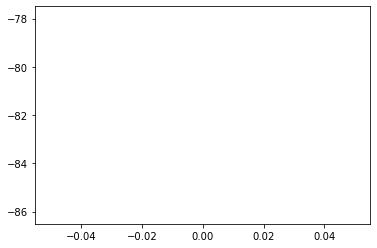

In [11]:

from mayavi import mlab
mlab.options.offscreen = False
mlab.figure(size=(1680,1050))

stims=[]
'''
stims.append(h.epsp(soma(0.5)))
stims[0].onset = 0.05
stims[0].imax = 20
'''

for i in section_index[::300]:
    print()
    s = h.epsp(dend[i](0.5))
    s.onset = 0.1
    s.imax = 5
    stims.append(s)

g = h.graph()
v_vec = h.Vector()        # Membrane potential vector
t_vec = h.Vector()        # Time stamp vector
v_vec.record(dend[section_index[1000]](0.5)._ref_v)
t_vec.record(h._ref_t)





h.load_file('stdrun.hoc')
h.finitialize(-82)
h.dt=0.01
plot_coordinates[0,:] = plot_coordinates[0,:] - np.median(plot_coordinates[0,:])
plot_coordinates[1,:] = plot_coordinates[1,:] - np.median(plot_coordinates[1,:])
plot_coordinates[2,:] = plot_coordinates[2,:] - np.median(plot_coordinates[2,:])
points = mlab.pipeline.scalar_scatter(plot_coordinates[0,:], plot_coordinates[1,:], plot_coordinates[2,:], plot_diameter)
dataset = points.mlab_source.dataset
dataset.point_data.get_array(0).name = 'diameter'
dataset.lines = connections
dataset.point_data.update()

# The tube
src = mlab.pipeline.set_active_attribute(points, point_scalars='diameter')
stripper = mlab.pipeline.stripper(src)
tube = mlab.pipeline.tube(stripper, tube_sides = 6, tube_radius = 1)
tube.filter.capping = True
#        tube.filter.use_default_normal = False
tube.filter.vary_radius = 'vary_radius_by_absolute_scalar'
tube.children = [] # Removing the old ones 

array_id = dataset.point_data.add_array(init_potential)
dataset.point_data.get_array(array_id).name = 'voltage'
dataset.point_data.update()
src2 = mlab.pipeline.set_active_attribute(tube, 
                                            point_scalars='voltage')
surf = mlab.pipeline.surface(src2, colormap='gist_heat')

cb=mlab.colorbar(object=surf,nb_labels=10)
lut=surf.module_manager.scalar_lut_manager.lut.table.to_array()
lut[:,3]=np.linspace(0,255,256)
lut[0:10,3]=np.zeros(10)+10

surf.module_manager.scalar_lut_manager.lut.table = lut
surf.module_manager.scalar_lut_manager.use_default_range=False
membrane_potential = np.zeros(len(plot_diameter))
#mlab.show()


@mlab.animate(delay=100)
def anim():
    surf.actor.actor.rotate_y(40)
    surf.actor.actor.rotate_x(-30)
    surf.actor.actor.rotate_z(30)
    surf.actor.actor.rotate_x(-90)
    #surf.actor.actor.rotate_y(45)
    #f = mlab.gcf()

    for i in range(1500):
        
        surf.actor.actor.rotate_x(0.2)        
        
        h.fadvance()
        
        i_seg = 0
        N = soma.n3d()
        print(i,h.t)
        
        for seg in range(soma.n3d()):
            membrane_potential[i_seg]=soma(soma.arc3d(seg)/soma.L).v
            i_seg = i_seg + 1
        
        
        for i_sec in section_index:
            N=N+dend[i_sec].n3d()
            for seg in range(dend[i_sec].n3d()):
                membrane_potential[i_seg]=dend[i_sec](dend[i_sec].arc3d(seg)/dend[i_sec].L).v
                i_seg = i_seg + 1
        
        dataset.point_data.remove_array(1)
        dataset.point_data.update()
        
        # Adding the new scalar
        dataset.point_data.add_array(membrane_potential)
        dataset.point_data.get_array(1).name = 'voltage'
        dataset.point_data.update()
        #mlab.draw()
        
        # Updating the dataset
        #ms = surf.mlab_source
        #ms.m_data.update()

        #surf.mlab_source.voltage = np.ones(10)*i*200
        #f.scene.render()
        mlab.process_ui_events()
        
        yield
        mlab.savefig('video/screenshots/image'+str(i)+'.png')
        
anim()
mlab.show()

import matplotlib.pyplot as plt
plt.plot(t_vec, v_vec)
plt.show()

In [4]:
import cv2
import numpy as np
import glob

frameSize = (1680, 1007)

out = cv2.VideoWriter('video/output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, frameSize)
for i in range(1500):
    img = cv2.imread('video/screenshots/image'+str(i)+'.png')
    out.write(img)

out.release()